# Финальный проект. Анализ данных такси.
## Неделя 1. Задание 2
### Работа с геоданными

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats as sts
import os
import urllib.request
import sys


from mpl_toolkits.basemap import Basemap
from matplotlib import cm

np.set_printoptions(precision=5, floatmode='maxprec', suppress=True)
%matplotlib inline

In [2]:
#data = pd.read_csv('data/yellow_tripdata_2016-05.csv', nrows = 10000)
#pivot = pd.read_csv('data/pivots/pivot_yellow_tripdata_2016-05.csv', index_col=0)
regions = pd.read_csv('regions.csv')
pivot = pd.read_csv('data/pivots/pivot_yellow_tripdata_2016-05.csv', index_col=0).reset_index(drop=True)
regions = pd.read_csv('regions.csv', sep = ';')
regions['trips'] = pivot.sum(axis=1)
#data.head()
#regions.head()

 ### Количество ячеек, из которых не было поездок

In [3]:
print(regions['trips'].sum())
print('Не было поездок из {} ячеек'.format((regions.trips == 0).sum()))

11626521
Не было поездок из 1283 ячеек


In [4]:
# Определим переменые, которые поадобятся в процессе визуализации
west, south, east, north = -74.25559, 40.49612, -73.70001, 40.91553 #Границы области NYC
esb_lat, esb_long = 40.748412, -73.985860                           # Координаты Эмпайр Стейт 

x = np.linspace(west, east, 50)                                     # границы ячеек
y = np.linspace(south, north, 50)                                   # границы ячеек
xx, yy = np.meshgrid(x, y)                                          # сетка для отрисовки ячеек
m = Basemap(projection='lcc', lon_0=esb_long, lat_0=esb_lat,
           llcrnrlon=west,llcrnrlat=south,
           urcrnrlon=east,urcrnrlat=north, resolution='h',)         # объект Basemap, в проекции 'lcc'
                                                                    # https://matplotlib.org/basemap/users/lcc.html


### Статическая карта Нью-Йорка

Text(22808.1,28018.6,'Empire State Building')

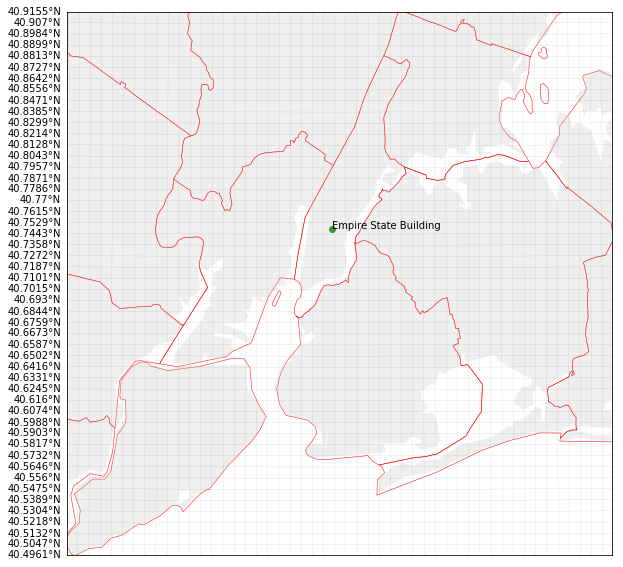

In [5]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
# Отрисовываем фон карты - границы округов, сетку ячеек и сушу
m.drawcounties(color='red',linewidth=.5)
m.drawparallels(y,linewidth=0.1,labels=[1,0,0,0])
m.drawmeridians(x,linewidth=0.1,labels=[0,0,0,0])
m.fillcontinents(alpha=0.3)

# расположение Empire State Building
m.scatter(esb_long, esb_lat, marker='o',
          latlon = True, color='green', label='ESB')
x_text,y_text = m(esb_long, esb_lat)
plt.text(x_text,y_text, 'Empire State Building')


### Статическая карта Нью-Йорка + "активность" ячеек

11626521


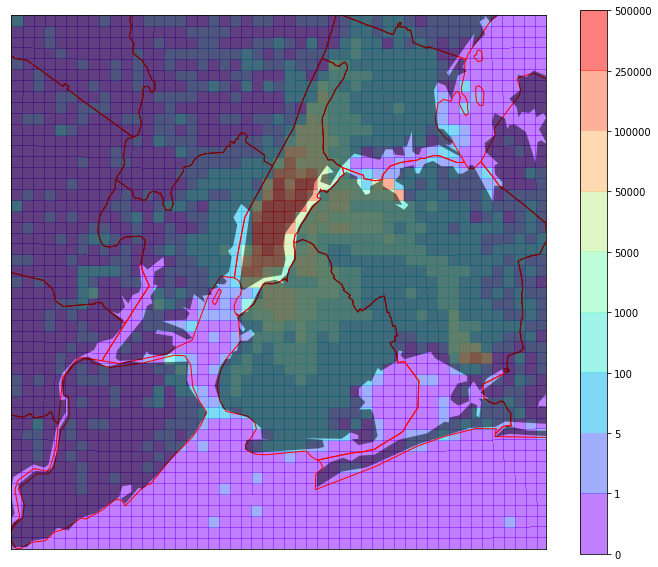

In [6]:
import matplotlib.colors as colors
# Сортировка файла с регионами, чтобы подогнать под рассчитанную ранее сетку
# При подгонке исходил из того, что наиболее активные ячейки должны находиться на Манхеттене
reg_copy = regions.sort_values(by=['north','west',],ascending=[True, True])
reg_copy.reset_index(drop=True, inplace=True)
reg_copy.head()
# Преобразование столбца с количеством поездок в массив 50х50
r1 = reg_copy.trips.values.reshape(50,50)
print(r1.sum().sum())


fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

# Параметры отрисовки
bounds = [0,.9,5,100,1000,5000,50000,100000,250000,500000]      # границы значений по количеству поездок, для задания цвета
cmap=plt.cm.rainbow                                             # импорт цветовой карты ('rainbow')
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)   # нормализация цветов, приведение к дискретным значеиям 
# Отрисовка карты и активости ячеек
aaa = m.pcolormesh(xx,yy, r1,alpha = .5, latlon=True,norm=norm, cmap=cmap, )  # тепловая карта по сетке
m.fillcontinents(alpha=.5,color='black')
m.drawcounties(color='red',linewidth=1)
fig.colorbar(aaa)

### Интерактивная карта Нью-Йорка + Статуя Свободы

In [7]:
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import WMTSTileSource
bokeh.__version__

'0.13.0'

In [8]:
# Функция для перевода широты и долготы в координаты для проекции "Web Mercator"
def wgs84_to_web_mercator(arr, coor ):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    if coor == 'lon':
        arr = arr * (k * np.pi/180.0)    
    elif coor == 'lat':
        arr = np.log(np.tan((90 + arr) * np.pi/360.0)) * k
    else:
        print('Specify the type of coordintes ("lon" or "lat")')
    return arr

In [9]:
# web mercator coordinates
NYC = x_range, y_range = np.array([-74.25559, -73.70001]), np.array([40.49612, 40.91553])
NYC = x_range, y_range = wgs84_to_web_mercator(x_range, 'lon'), wgs84_to_web_mercator(y_range, 'lat')
output_notebook()
p = figure(tools='pan, wheel_zoom, hover', x_range=x_range, y_range=y_range)
p.axis.visible = False
url = 'http://a.basemaps.cartocdn.com/dark_all/{Z}/{X}/{Y}.png'
attribution = "Tiles by Carto, under CC BY 3.0. Data by OSM, under ODbL"

# Statue of Liberty coordinates
k = 6378137
sl_lat, sl_lon = 40.689182, -74.044522
sl_lon_wm = sl_lon* (k * np.pi/180.0)
sl_lat_wm = np.log(np.tan((90 + sl_lat) * np.pi/360.0)) * k

Loading BokehJS ...

In [10]:
p.add_tile(WMTSTileSource(url=url, attribution=attribution))
p.circle(x=sl_lon_wm, y=sl_lat_wm, fill_color='orange', size=10)
p.text(x=sl_lon_wm, y=sl_lat_wm, text=bokeh.core.properties.value('Statue of Liberty'), text_color = 'firebrick')
show(p)

### Интерактивная карта Нью-Йорка + Среднее кол-во поездок

In [11]:
# Расчет новых столбцов для визуализации
## Среднее кол-во поездок
regions['avg_trips'] = regions.trips / 744
## Расчет координат вершин ячеек
x_coor = [np.array([regions.west[i], regions.east[i],regions.east[i],regions.west[i]]) 
                               for i in range(len(regions))]
y_coor = [np.array([regions.south[i], regions.south[i],regions.north[i],regions.north[i]]) 
                               for i in range(len(regions))]
## Конвертируем координаты в нужный для bokeh вид
regions['xs'] = list(wgs84_to_web_mercator(np.array(x_coor),'lon'))
regions['ys'] = list(wgs84_to_web_mercator(np.array(y_coor),'lat'))

## Разбиваем поездки по категориям (я так и не придумал, как это сделать сразу в процессе визуализации)
regions['color'] = [np.nan if regions.avg_trips[i] <5 else 
         1 if regions.avg_trips[i] < 30 else 
         2 if regions.avg_trips[i] < 50 else 
         3 if regions.avg_trips[i] < 100 else 
         4 if regions.avg_trips[i] < 250 else 
         5 if regions.avg_trips[i] < 500 else 6
        for i in range(len(regions))]
regions['label'] = ['under 5' if regions.avg_trips[i] <5 else 
         '5-30' if regions.avg_trips[i] < 30 else 
         '30-50' if regions.avg_trips[i] < 50 else 
         '50-100' if regions.avg_trips[i] < 100 else 
         '100-250' if regions.avg_trips[i] < 250 else 
         '250-500' if regions.avg_trips[i] < 500 else 'over 500'
        for i in range(len(regions))]
regions.head()

,region,west,east,south,north,trips,avg_trips,xs,ys,color,label
0,1,-74.25559,-74.244478,40.496120,40.504508,0,0.0,"[-8266094.467354097, -8264857.5297002, -826485...","[4938301.180328478, 4938301.180328478, 4939529...",NaN,under 5
1,2,-74.25559,-74.244478,40.504508,40.512896,0,0.0,"[-8266094.467354097, -8264857.5297002, -826485...","[4939529.175069497, 4939529.175069497, 4940757...",NaN,under 5
2,3,-74.25559,-74.244478,40.512896,40.521285,0,0.0,"[-8266094.467354097, -8264857.5297002, -826485...","[4940757.323391667, 4940757.323391667, 4941985...",NaN,under 5
3,4,-74.25559,-74.244478,40.521285,40.529673,0,0.0,"[-8266094.467354097, -8264857.5297002, -826485...","[4941985.625359734, 4941985.625359734, 4943214...",NaN,under 5
4,5,-74.25559,-74.244478,40.529673,40.538061,0,0.0,"[-8266094.467354097, -8264857.5297002, -826485...","[4943214.081038475, 4943214.081038475, 4944442...",NaN,under 5


In [12]:
from bokeh.models import ColumnDataSource
from bokeh.models import LogTicker
from bokeh.models import FixedTicker, FuncTickFormatter,TickFormatter

source = ColumnDataSource(regions)
p = figure(tools='pan, wheel_zoom, hover', x_range=x_range, y_range=y_range,)
p.axis.visible = False
p.add_tile(WMTSTileSource(url=url, attribution=attribution))
p.circle(x=sl_lon_wm, y=sl_lat_wm, fill_color='orange', size=10)
p.text(x=sl_lon_wm, y=sl_lat_wm, text=bokeh.core.properties.value('Statue of Liberty'), text_color = 'firebrick')

color_mapper = bokeh.models.LinearColorMapper(palette=bokeh.palettes.Viridis256)#, low = 5, low_color='grey')
p.patches('xs', 'ys',
          line_color='grey', source = source, line_width=.2, fill_alpha = 0.3,
          fill_color={'field': 'color', 'transform': color_mapper})

hover = p.select_one(bokeh.models.HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = u"""
<div> 
    <div class="bokeh_hover_tooltip">Region number : @region</div>  
    <div class="bokeh_hover_tooltip">Total trips : @trips</div>
    <div class="bokeh_hover_tooltip">Average trips by hour: @avg_trips{0.00}</div>
    <div class="bokeh_hover_tooltip">Group by average trips : @label</div>
</div>
"""

color_bar = bokeh.models.ColorBar(color_mapper=color_mapper,
                                  label_standoff=12, border_line_color=None, location=(0,0), )
p.add_layout(color_bar, 'right')
show(p)

На карте серым цветом залиты ячейки, из которых было в среднем менее чем 5 поездок в час. Остальные разбиты на 6 групп и по цветам (от темного к светлому). Ячейки с большим количеством поездок в "невозможных" местах не наблюдаются

P.S. К сожалению, не получилось отрисовать метки на colorbar'е

In [13]:
labels, counts = np.unique(regions.label, return_counts=True)
pd.DataFrame({'label':labels, 'count':counts})

,label,count
0,100-250,15
1,250-500,16
2,30-50,8
3,5-30,46
4,50-100,9
5,over 500,8
6,under 5,2398
